## Setup

Import the main DL library and check versions. Install pytorch interface for BERT from HuggingFace. Additionally import torch, query GPU, init device.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# !pip install pytorch-pretrained-bert pytorch-nlp
# !pip install urllib3==1.26.3

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


TensorFlow version: 2.9.2
Found GPU at: /device:GPU:0


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertForMaskedLM
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

# Longest sentence is probably less than 10, but we leave room anyway. In the original paper, the authors used a length of 512.
MAX_LEN = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
# "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large")
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model_read = BertForMaskedLM.from_pretrained("bert-base-uncased")
model_read.cuda()

model_genr = BertForMaskedLM.from_pretrained("bert-base-uncased")
model_genr.cuda()

param_optimizer = list(model_genr.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 906073.90B/s]


## Dataset and Preprocessing


Load tsv file from drive.

In [4]:
from google.colab import drive

# drive.mount('/content/private_do_not_access')
# !ln -s "/content/private_do_not_access/MyDrive/Colab Notebooks/HML Project/data" "/content/data"

drive.mount('/content/drive',force_remount=True)

# !ln - s "/content/drive/MyDrive/HML Project/data"

Mounted at /content/drive


In [5]:
# df = pd.read_csv("data/sample_slamecka_graf.tsv", delimiter='\t', header=None, names=['rule', 'stimulus', 'response'])
# df.shape

# df_main = pd.read_excel("data/custom_all.xlsx")
# df_main.shape

# df = pd.read_csv("data/custom_cleaned_balanced.csv", delimiter=',', header=None, names=['idx', 'rule', 'stimulus', 'response', 'invalid'])
# df = pd.read_csv("data/custom_cleaned_balanced.csv", names=['idx', 'rule', 'stimulus', 'response', 'invalid'])

# df = pd.read_csv("data/custom_cleaned_balanced.csv")

df = pd.read_csv("/content/drive/MyDrive/HML Project/data/custom_cleaned_balanced.csv")
df.shape

df.sample(6)

,Unnamed: 0,rule,stimulus,response,multi_toks_or_oov
151,151,associate,surgery,hospital,False
1433,1433,synonym,repeat,double,False
1311,1311,antonym,far,near,False
1270,1270,antonym,regular,irregular,False
1691,1691,synonym,addition,increase,False
1724,1724,synonym,refer,cite,False


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, stratify=df['rule'])

In [7]:
np.unique(train_df['rule'], return_counts=True)

(array(['antonym', 'associate', 'category', 'rhyme', 'synonym'],
       dtype=object), array([354, 354, 355, 354, 355]))

In [8]:
np.unique(test_df['rule'], return_counts=True)

(array(['antonym', 'associate', 'category', 'rhyme', 'synonym'],
       dtype=object), array([89, 89, 88, 89, 88]))

In [9]:
  # # df1 = df_main.sample(10000)
# df1 = df_main
# print(df1['Rule'].unique())

# def clean_phrase(item):
#   str_tks = tokenizer.tokenize(str(item))
#   len_tks = len(str_tks)
#   str_low = str_tks[0]
#   if len_tks == 2 and str_tks[0] in ['a', 'an']:
#     str_low = str_tks[1]
#     len_tks = 1
#   elif len_tks >= 2:
#     str_low = str(item).strip().lower()
#   return str_low, len_tks

# def build_row(row):
#   rule_word = str(row[0]).strip().lower()
#   stim_word, stim_len = clean_phrase(row[1])
#   resp_word, resp_len = clean_phrase(row[2])
#   return pd.Series([rule_word, stim_word, resp_word, stim_len > 1 or resp_len > 1 or stim_word == resp_word])

# df1 = df1.apply(build_row, axis=1)
# df1 = df1.rename(columns={0: 'rule', 1: 'stimulus', 2: 'response', 3: 'multi_toks_or_oov'})

# # df1[df1['rule'] == 'category'].sample(6)
# df1.sample(6)

In [10]:
# print('Befor filtering multi-token rows', df1.shape, df1['rule'].unique())
# df1 = df1[df1['multi_toks_or_oov'] == False]
# print('After filtering multi-token rows', df1.shape, df1['rule'].unique())

# print(df1.groupby('rule').size())

# samples_per_class = df1.groupby('rule').size().min()
# dfs_list = []
# for rule in df1['rule'].unique():
#   dfs_list.append(df1[df1['rule'] == rule].sample(samples_per_class))
# df2 = pd.concat(dfs_list, ignore_index=True)

# print(df2.groupby('rule').size())

# print(df2.sample(6))
# print(df2.to_csv('data/custom_cleaned_balanced.csv'))

# df = df2

Create sentences from tsv file and template, tokenize for BERT - for training model_genr.

In [11]:
from collections import OrderedDict

template_rule = OrderedDict()
template_rule['associate'] = 'associate'
template_rule['category'] = 'example'
template_rule['antonym'] = 'opposite'
template_rule['synonym'] = 'synonym'
template_rule['rhyme'] = 'rhyme'

def train_mask(df):
  # Create sentences using dataset and template
  masked_sentences = []
  target_words = []

  for idx, item in df.iterrows():
    ms = f"[CLS] {item['stimulus']} is {template_rule[item['rule']]} of [MASK] [SEP]"
    ts = (5, item['response'])
    masked_sentences.append(ms)
    target_words.append(ts)
  return masked_sentences, target_words

In [12]:
train_sentences, train_targets = train_mask(train_df)
print(train_sentences[0:10])
print(train_targets[0:10])

['[CLS] prick is rhyme of [MASK] [SEP]', '[CLS] sane is opposite of [MASK] [SEP]', '[CLS] tree is example of [MASK] [SEP]', '[CLS] limited is opposite of [MASK] [SEP]', '[CLS] vegetables is associate of [MASK] [SEP]', '[CLS] refuse is associate of [MASK] [SEP]', '[CLS] shack is rhyme of [MASK] [SEP]', '[CLS] post is synonym of [MASK] [SEP]', '[CLS] charge is rhyme of [MASK] [SEP]', '[CLS] hem is rhyme of [MASK] [SEP]']
[(5, 'slick'), (5, 'insane'), (5, 'christmas'), (5, 'unlimited'), (5, 'good'), (5, 'garbage'), (5, 'pack'), (5, 'brand'), (5, 'jar'), (5, 'team')]


In [13]:
def train_tokenize(masked_sentences, target_words):
  
  input_ids = []
  label_ids = []

  for ms, ts in zip(masked_sentences, target_words):
    idinp = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ms))
    input_ids.append(idinp)

    idout = [-1 for _ in range(len(idinp))]
    idout[ts[0]] = tokenizer.convert_tokens_to_ids([ts[1]])[0]
    label_ids.append(idout)

  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  label_ids = pad_sequences(label_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post", value=-1)

  # Create attention masks
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  return input_ids, label_ids, attention_masks

In [14]:
t_input_ids, t_label_ids, t_attention_masks = train_tokenize(train_sentences, train_targets)

print (len(t_input_ids), len(t_label_ids))
print ("Tokenized first sentence:")
print (train_sentences[0], t_input_ids[0])
print (train_targets[0], t_label_ids[0])

1772 1772
Tokenized first sentence:
[CLS] prick is rhyme of [MASK] [SEP] [  101 24858  2003 20622  1997   103   102     0     0     0     0     0
     0     0     0     0]
(5, 'slick') [   -1    -1    -1    -1    -1 13554    -1    -1    -1    -1    -1    -1
    -1    -1    -1    -1]


Create sentences from tsv file and template, tokenize for BERT - for testing model_read, model_genr.

In [15]:
def eval_mask(df):

  # Create sentences using dataset and template
  masked_sentences = []
  target_words = []

  for idx, item in df.iterrows():
    ms = f"[CLS] {item['stimulus']} is [MASK] of {item['response']} [SEP]"
    ts = (3, template_rule[item['rule']])
    masked_sentences.append(ms)
    target_words.append(ts)

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  return masked_sentences, target_words
  

In [16]:
eval_sentences, eval_targets = eval_mask(train_df)
print(eval_sentences[0:10])
print(eval_targets[0:10])

['[CLS] prick is [MASK] of slick [SEP]', '[CLS] sane is [MASK] of insane [SEP]', '[CLS] tree is [MASK] of christmas [SEP]', '[CLS] limited is [MASK] of unlimited [SEP]', '[CLS] vegetables is [MASK] of good [SEP]', '[CLS] refuse is [MASK] of garbage [SEP]', '[CLS] shack is [MASK] of pack [SEP]', '[CLS] post is [MASK] of brand [SEP]', '[CLS] charge is [MASK] of jar [SEP]', '[CLS] hem is [MASK] of team [SEP]']
[(3, 'rhyme'), (3, 'opposite'), (3, 'example'), (3, 'opposite'), (3, 'associate'), (3, 'associate'), (3, 'rhyme'), (3, 'synonym'), (3, 'rhyme'), (3, 'rhyme')]


In [17]:
def eval_tokenize(masked_sentences, target_words):
  input_ids = []
  label_ids = []

  for ms, ts in zip(masked_sentences, target_words):
    idinp = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ms))
    input_ids.append(idinp)

    idout = [-1 for _ in range(len(idinp))]
    idout[ts[0]] = tokenizer.convert_tokens_to_ids([ts[1]])[0]
    label_ids.append(idout)

  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  label_ids = pad_sequences(label_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post", value=-1)

  # Create attention masks
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

  return input_ids, label_ids, attention_masks

In [18]:
e_input_ids, e_label_ids, e_attention_masks = eval_tokenize(eval_sentences, eval_targets)

print (len(e_input_ids), len(e_label_ids))
print ("Tokenized first sentence:")
print (eval_sentences[0], e_input_ids[0])
print (eval_targets[0], e_label_ids[0])

1772 1772
Tokenized first sentence:
[CLS] prick is [MASK] of slick [SEP] [  101 24858  2003   103  1997 13554   102     0     0     0     0     0
     0     0     0     0]
(3, 'rhyme') [   -1    -1    -1 20622    -1    -1    -1    -1    -1    -1    -1    -1
    -1    -1    -1    -1]


In [19]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 16

# Convert all of our data into torch tensors, the required datatype for our model
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
train_inputs = torch.tensor(t_input_ids)
train_masks = torch.tensor(t_attention_masks)
train_labels = torch.tensor(t_label_ids)
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

eval_inputs = torch.tensor(e_input_ids)
eval_masks = torch.tensor(e_attention_masks)
eval_labels = torch.tensor(e_label_ids)
eval_data = TensorDataset(eval_inputs, eval_masks, eval_labels)

eval_sampler = RandomSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)

## Train Model

Evaluation helper functions.

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)  

rule_vocab_ids = tokenizer.convert_tokens_to_ids([y for x, y in template_rule.items()])
vocab_id_to_rule_id = {id: i for i, id in enumerate(rule_vocab_ids)}

def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

# Function to calculate the accuracy among five template words
def confusion_matrix_rules(preds, labels, tok_pos=3):
    rule_preds = preds[:, tok_pos, rule_vocab_ids]
    rule_labels = labels[:, tok_pos]
    rule_labels = np.array([vocab_id_to_rule_id[x] for x in rule_labels])
    labels_flat = rule_labels.flatten()
    predts_flat = np.argmax(rule_preds, axis=1).flatten()

    labels_mat = one_hot(labels_flat, 5).reshape([-1, 5, 1])
    predts_mat = one_hot(predts_flat, 5).reshape([-1, 1, 5])
    counts_mat = np.sum(predts_mat * labels_mat, axis=0)
      # print(labels_flat, predts_flat)
    # print(counts_mat)
    return counts_mat

accuracy_per_class = lambda mat: np.diag(mat) / np.sum(mat, axis=1)

Run training to learn to predict the response word.

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []
evaln_matr_set = []
loss_per_epoch = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 100

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Evaluation
  # Put model in evaluation mode to evaluate loss on the validation set
  model_read.eval()
  model_genr.eval()

  # Tracking variables 
  eval_matrix_read = np.zeros((5, 5))
  eval_matrix_genr = np.zeros((5, 5))

  # Evaluate data for one epoch
  for batch in eval_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model_read(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    eval_matrix_read += confusion_matrix_rules(logits, label_ids)

    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model_genr(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    eval_matrix_genr += confusion_matrix_rules(logits, label_ids)

  evaln_matr_set.append((eval_matrix_read, eval_matrix_genr))
  print('\nEval Accuracy - Read:', accuracy_per_class(eval_matrix_read))
  print('\nEval Accuracy - Genr:', accuracy_per_class(eval_matrix_genr))

  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model_genr.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model_genr(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, masked_lm_labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

    # print(loss.item())
  
  print("\nTrain loss: {}".format(tr_loss/nb_tr_steps))
  loss_per_epoch.append(tr_loss/nb_tr_steps)

np.save("/content/drive/MyDrive/HML Project/data/confusion_matrices_test.npy", evaln_matr_set)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]


/usr/local/lib/python3.8/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch:   1%|          | 1/100 [00:24<40:23, 24.48s/it]


Train loss: 6.795124852979505

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.06779661 0.11267606 0.88135593 0.01408451 0.01977401]


Epoch:   2%|▏         | 2/100 [00:46<38:02, 23.29s/it]


Train loss: 4.17019695419449

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16666667 0.09577465 0.75988701 0.08450704 0.01694915]


Epoch:   3%|▎         | 3/100 [01:08<36:42, 22.71s/it]


Train loss: 2.719513721294231

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15536723 0.06197183 0.78813559 0.05915493 0.01412429]


Epoch:   4%|▍         | 4/100 [01:31<36:09, 22.60s/it]


Train loss: 2.0174660677308434

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12146893 0.08169014 0.69491525 0.12112676 0.02542373]


Epoch:   5%|▌         | 5/100 [01:53<35:41, 22.55s/it]


Train loss: 1.6159533350854307

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.13276836 0.09295775 0.69774011 0.13802817 0.0480226 ]


Epoch:   6%|▌         | 6/100 [02:15<35:04, 22.39s/it]


Train loss: 1.3544731712019122

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.10734463 0.07042254 0.74576271 0.11267606 0.01129944]


Epoch:   7%|▋         | 7/100 [02:38<34:35, 22.31s/it]


Train loss: 1.2455332708788347

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.11016949 0.06478873 0.7740113  0.07605634 0.03954802]


Epoch:   8%|▊         | 8/100 [03:00<34:09, 22.28s/it]


Train loss: 1.1590530509884294

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.10169492 0.09014085 0.66666667 0.16901408 0.05649718]


Epoch:   9%|▉         | 9/100 [03:22<33:45, 22.25s/it]


Train loss: 1.1070497364879728

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1299435  0.10422535 0.68644068 0.12394366 0.04519774]


Epoch:  10%|█         | 10/100 [03:44<33:15, 22.18s/it]


Train loss: 1.07487286466199

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.12957746 0.59887006 0.12676056 0.03954802]


Epoch:  11%|█         | 11/100 [04:06<32:50, 22.14s/it]


Train loss: 1.0603231566177833

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1299435  0.16338028 0.63841808 0.12394366 0.05649718]


Epoch:  12%|█▏        | 12/100 [04:28<32:25, 22.10s/it]


Train loss: 1.0190100983993426

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15536723 0.14647887 0.65536723 0.11267606 0.09887006]


Epoch:  13%|█▎        | 13/100 [04:51<32:26, 22.37s/it]


Train loss: 1.0055171707728963

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14689266 0.14647887 0.59887006 0.18873239 0.06779661]


Epoch:  14%|█▍        | 14/100 [05:13<31:56, 22.29s/it]


Train loss: 0.9904072251808536

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12429379 0.15774648 0.66666667 0.11830986 0.06497175]


Epoch:  15%|█▌        | 15/100 [05:35<31:30, 22.24s/it]


Train loss: 0.9775648549333349

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.11299435 0.14647887 0.61016949 0.18309859 0.10169492]


Epoch:  16%|█▌        | 16/100 [05:57<31:05, 22.21s/it]


Train loss: 0.9656490919826267

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.11864407 0.17746479 0.63276836 0.11267606 0.16101695]


Epoch:  17%|█▋        | 17/100 [06:19<30:39, 22.16s/it]


Train loss: 0.9540791073897937

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.11864407 0.14366197 0.62146893 0.18309859 0.09322034]


Epoch:  18%|█▊        | 18/100 [06:42<30:14, 22.13s/it]


Train loss: 0.9510510853818945

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12429379 0.18028169 0.64971751 0.09014085 0.05367232]


Epoch:  19%|█▉        | 19/100 [07:04<29:50, 22.10s/it]


Train loss: 0.9469955542066075

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.11299435 0.14929577 0.65536723 0.09295775 0.09322034]


Epoch:  20%|██        | 20/100 [07:26<29:25, 22.07s/it]


Train loss: 0.9286625672568072

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1440678  0.17746479 0.61016949 0.07605634 0.09039548]


Epoch:  21%|██        | 21/100 [07:48<29:15, 22.22s/it]


Train loss: 0.9356120810046926

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.13276836 0.18028169 0.63841808 0.08450704 0.12429379]


Epoch:  22%|██▏       | 22/100 [08:10<28:49, 22.17s/it]


Train loss: 0.9156879423572136

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1299435  0.21971831 0.61581921 0.06478873 0.07344633]


Epoch:  23%|██▎       | 23/100 [08:32<28:23, 22.12s/it]


Train loss: 0.9131283879212968

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14124294 0.17746479 0.62429379 0.06478873 0.07627119]


Epoch:  24%|██▍       | 24/100 [08:54<27:56, 22.06s/it]


Train loss: 0.9128274758019157

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15254237 0.2084507  0.62429379 0.07323944 0.11299435]


Epoch:  25%|██▌       | 25/100 [09:16<27:32, 22.03s/it]


Train loss: 0.8971039060805295

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1440678  0.24788732 0.61016949 0.06478873 0.09039548]


Epoch:  26%|██▌       | 26/100 [09:38<27:09, 22.02s/it]


Train loss: 0.9043875384975124

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1440678  0.1943662  0.58474576 0.08732394 0.0960452 ]


Epoch:  27%|██▋       | 27/100 [10:00<26:45, 21.99s/it]


Train loss: 0.9015834767807711

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.21408451 0.54519774 0.08732394 0.08474576]


Epoch:  28%|██▊       | 28/100 [10:22<26:23, 22.00s/it]


Train loss: 0.9054850098249074

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.21971831 0.61016949 0.06478873 0.09039548]


Epoch:  29%|██▉       | 29/100 [10:44<26:12, 22.15s/it]


Train loss: 0.9047188119174124

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.22535211 0.57062147 0.07323944 0.11299435]


Epoch:  30%|███       | 30/100 [11:06<25:47, 22.10s/it]


Train loss: 0.882930682183386

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.21408451 0.59322034 0.06197183 0.15254237]


Epoch:  31%|███       | 31/100 [11:28<25:21, 22.06s/it]


Train loss: 0.8749852759075595

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.27887324 0.49435028 0.08169014 0.09887006]


Epoch:  32%|███▏      | 32/100 [11:51<25:00, 22.06s/it]


Train loss: 0.8860426335721403

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.23661972 0.55649718 0.08169014 0.1779661 ]


Epoch:  33%|███▎      | 33/100 [12:12<24:36, 22.03s/it]


Train loss: 0.8741138933209686

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14124294 0.28450704 0.50847458 0.07042254 0.11581921]


Epoch:  34%|███▍      | 34/100 [12:34<24:12, 22.01s/it]


Train loss: 0.8758261119191711

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16949153 0.30422535 0.47175141 0.08732394 0.15254237]


Epoch:  35%|███▌      | 35/100 [12:56<23:50, 22.00s/it]


Train loss: 0.8573390002454724

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.27887324 0.52824859 0.08450704 0.0960452 ]


Epoch:  36%|███▌      | 36/100 [13:19<23:33, 22.09s/it]


Train loss: 0.8753229134992974

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18079096 0.23380282 0.50564972 0.10704225 0.07909605]


Epoch:  37%|███▋      | 37/100 [13:41<23:13, 22.12s/it]


Train loss: 0.8705379447421512

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.23380282 0.48022599 0.10422535 0.12146893]


Epoch:  38%|███▊      | 38/100 [14:04<23:03, 22.32s/it]


Train loss: 0.8565693729229875

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14971751 0.23661972 0.49152542 0.12957746 0.14124294]


Epoch:  39%|███▉      | 39/100 [14:26<22:33, 22.19s/it]


Train loss: 0.8764776768569775

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.21690141 0.52824859 0.10422535 0.12711864]


Epoch:  40%|████      | 40/100 [14:48<22:08, 22.15s/it]


Train loss: 0.8591998278557718

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16666667 0.23380282 0.52259887 0.10140845 0.12711864]


Epoch:  41%|████      | 41/100 [15:10<21:43, 22.09s/it]


Train loss: 0.8613977195980312

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.21971831 0.48870056 0.11549296 0.1299435 ]


Epoch:  42%|████▏     | 42/100 [15:32<21:19, 22.06s/it]


Train loss: 0.8530443604985202

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.24788732 0.43220339 0.13239437 0.09039548]


Epoch:  43%|████▎     | 43/100 [15:54<20:56, 22.04s/it]


Train loss: 0.8543135347264307

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1920904  0.23943662 0.48022599 0.07605634 0.10169492]


Epoch:  44%|████▍     | 44/100 [16:15<20:32, 22.00s/it]


Train loss: 0.8558283026019732

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1779661  0.23098592 0.49152542 0.10422535 0.13559322]


Epoch:  45%|████▌     | 45/100 [16:38<20:10, 22.02s/it]


Train loss: 0.8513199311790166

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16666667 0.23943662 0.52259887 0.09014085 0.0960452 ]


Epoch:  46%|████▌     | 46/100 [17:00<19:57, 22.18s/it]


Train loss: 0.8540953637713248

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1440678  0.25915493 0.53389831 0.09014085 0.08757062]


Epoch:  47%|████▋     | 47/100 [17:22<19:33, 22.14s/it]


Train loss: 0.8562341819743853

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15819209 0.23380282 0.49717514 0.09859155 0.11581921]


Epoch:  48%|████▊     | 48/100 [17:44<19:09, 22.11s/it]


Train loss: 0.8521588509147232

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.22253521 0.5480226  0.06760563 0.11864407]


Epoch:  49%|████▉     | 49/100 [18:06<18:46, 22.10s/it]


Train loss: 0.8414260726925489

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.20338983 0.21126761 0.49435028 0.11549296 0.18361582]


Epoch:  50%|█████     | 50/100 [18:28<18:22, 22.05s/it]


Train loss: 0.8379591433583079

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16666667 0.26197183 0.5        0.05915493 0.09039548]


Epoch:  51%|█████     | 51/100 [18:50<18:00, 22.06s/it]


Train loss: 0.8427558746566443

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16949153 0.25915493 0.50564972 0.05633803 0.12711864]


Epoch:  52%|█████▏    | 52/100 [19:12<17:38, 22.05s/it]


Train loss: 0.8447806874776745

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.27323944 0.4519774  0.05633803 0.07909605]


Epoch:  53%|█████▎    | 53/100 [19:34<17:14, 22.01s/it]


Train loss: 0.8447929429108495

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.20621469 0.27887324 0.46045198 0.07605634 0.1299435 ]


Epoch:  54%|█████▍    | 54/100 [19:56<16:52, 22.00s/it]


Train loss: 0.8359443208387306

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.26478873 0.48870056 0.08169014 0.13841808]


Epoch:  55%|█████▌    | 55/100 [20:19<16:37, 22.17s/it]


Train loss: 0.8423383919236896

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.27887324 0.49152542 0.06760563 0.10169492]


Epoch:  56%|█████▌    | 56/100 [20:41<16:13, 22.12s/it]


Train loss: 0.8311707557321669

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.24788732 0.52542373 0.07042254 0.23163842]


Epoch:  57%|█████▋    | 57/100 [21:03<15:48, 22.05s/it]


Train loss: 0.825738645434539

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.27042254 0.51977401 0.06478873 0.11299435]


Epoch:  58%|█████▊    | 58/100 [21:25<15:25, 22.03s/it]


Train loss: 0.8410552630016396

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15254237 0.27605634 0.4039548  0.09577465 0.11299435]


Epoch:  59%|█████▉    | 59/100 [21:47<15:03, 22.03s/it]


Train loss: 0.8391506679624587

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.20903955 0.23380282 0.49435028 0.08732394 0.12146893]


Epoch:  60%|██████    | 60/100 [22:09<14:40, 22.01s/it]


Train loss: 0.8344377997490737

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.24293785 0.24507042 0.49717514 0.07042254 0.10734463]


Epoch:  61%|██████    | 61/100 [22:31<14:17, 21.98s/it]


Train loss: 0.8314756479886201

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.19491525 0.24225352 0.49435028 0.07323944 0.10734463]


Epoch:  62%|██████▏   | 62/100 [22:52<13:55, 21.98s/it]


Train loss: 0.8308747953794025

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17514124 0.26760563 0.44632768 0.09295775 0.13276836]


Epoch:  63%|██████▎   | 63/100 [23:15<13:34, 22.02s/it]


Train loss: 0.8202524608051455

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16666667 0.30140845 0.4039548  0.07605634 0.14689266]


Epoch:  64%|██████▍   | 64/100 [23:37<13:18, 22.18s/it]


Train loss: 0.8250353191685569

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14971751 0.26760563 0.53107345 0.07323944 0.17231638]


Epoch:  65%|██████▌   | 65/100 [23:59<12:54, 22.14s/it]


Train loss: 0.828061913047825

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16101695 0.28450704 0.49152542 0.06760563 0.11864407]


Epoch:  66%|██████▌   | 66/100 [24:21<12:31, 22.10s/it]


Train loss: 0.8331661240474598

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15819209 0.30422535 0.48870056 0.06478873 0.13841808]


Epoch:  67%|██████▋   | 67/100 [24:43<12:07, 22.06s/it]


Train loss: 0.8237182064367844

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.20338983 0.27887324 0.52824859 0.04225352 0.16384181]


Epoch:  68%|██████▊   | 68/100 [25:05<11:45, 22.03s/it]


Train loss: 0.8311177575373435

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.19774011 0.27042254 0.47457627 0.05915493 0.14689266]


Epoch:  69%|██████▉   | 69/100 [25:27<11:21, 21.98s/it]


Train loss: 0.8315497788491549

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.19774011 0.26760563 0.52824859 0.04225352 0.14124294]


Epoch:  70%|███████   | 70/100 [25:49<10:59, 21.98s/it]


Train loss: 0.8216983873967652

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18079096 0.30422535 0.46892655 0.04788732 0.09887006]


Epoch:  71%|███████   | 71/100 [26:11<10:37, 21.97s/it]


Train loss: 0.8238542824983597

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.29859155 0.45762712 0.05352113 0.12711864]


Epoch:  72%|███████▏  | 72/100 [26:33<10:18, 22.10s/it]


Train loss: 0.8246195165960638

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18079096 0.26478873 0.47457627 0.03943662 0.09322034]


Epoch:  73%|███████▎  | 73/100 [26:55<09:55, 22.04s/it]


Train loss: 0.8209121431316342

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.13841808 0.34084507 0.44067797 0.05352113 0.10451977]


Epoch:  74%|███████▍  | 74/100 [27:17<09:32, 22.03s/it]


Train loss: 0.8209926633684484

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12711864 0.31267606 0.46327684 0.06197183 0.08474576]


Epoch:  75%|███████▌  | 75/100 [27:39<09:10, 22.03s/it]


Train loss: 0.8218602235387037

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18644068 0.27042254 0.4519774  0.06478873 0.1920904 ]


Epoch:  76%|███████▌  | 76/100 [28:01<08:48, 22.01s/it]


Train loss: 0.8187361626743196

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.31549296 0.50282486 0.04507042 0.10734463]


Epoch:  77%|███████▋  | 77/100 [28:23<08:25, 21.97s/it]


Train loss: 0.8224576770386718

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.31549296 0.52542373 0.03943662 0.14689266]


Epoch:  78%|███████▊  | 78/100 [28:45<08:03, 21.96s/it]


Train loss: 0.8135324849470241

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.13276836 0.44225352 0.40112994 0.03943662 0.14689266]


Epoch:  79%|███████▉  | 79/100 [29:07<07:40, 21.95s/it]


Train loss: 0.8128182686663963

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.20056497 0.28450704 0.42655367 0.08169014 0.1440678 ]


Epoch:  80%|████████  | 80/100 [29:29<07:18, 21.95s/it]


Train loss: 0.8220204428375304

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.21751412 0.31267606 0.42372881 0.04507042 0.12429379]


Epoch:  81%|████████  | 81/100 [29:51<07:00, 22.12s/it]


Train loss: 0.8128963198412109

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.21751412 0.32394366 0.44632768 0.03661972 0.14971751]


Epoch:  82%|████████▏ | 82/100 [30:13<06:37, 22.07s/it]


Train loss: 0.8186058038258338

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.17231638 0.32112676 0.47457627 0.06478873 0.11864407]


Epoch:  83%|████████▎ | 83/100 [30:35<06:14, 22.02s/it]


Train loss: 0.811207433004637

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14971751 0.31267606 0.46327684 0.06478873 0.1440678 ]


Epoch:  84%|████████▍ | 84/100 [30:57<05:52, 22.02s/it]


Train loss: 0.8090661165413556

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.13276836 0.31830986 0.46610169 0.09577465 0.12711864]


Epoch:  85%|████████▌ | 85/100 [31:19<05:29, 21.96s/it]


Train loss: 0.8026227670478391

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1299435  0.33239437 0.44350282 0.08169014 0.09039548]


Epoch:  86%|████████▌ | 86/100 [31:41<05:07, 21.96s/it]


Train loss: 0.8084194669793654

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18079096 0.30140845 0.42372881 0.06197183 0.24293785]


Epoch:  87%|████████▋ | 87/100 [32:03<04:45, 21.97s/it]


Train loss: 0.814273293222393

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.16384181 0.30140845 0.4519774  0.05915493 0.17514124]


Epoch:  88%|████████▊ | 88/100 [32:25<04:23, 21.96s/it]


Train loss: 0.8115688861087635

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18926554 0.30422535 0.39830508 0.05915493 0.09322034]


Epoch:  89%|████████▉ | 89/100 [32:47<04:01, 21.93s/it]


Train loss: 0.8113668625922622

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15254237 0.28450704 0.46892655 0.11549296 0.11581921]


Epoch:  90%|█████████ | 90/100 [33:09<03:41, 22.12s/it]


Train loss: 0.8131093841899807

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.21751412 0.23943662 0.46327684 0.07887324 0.18079096]


Epoch:  91%|█████████ | 91/100 [33:31<03:18, 22.07s/it]


Train loss: 0.8041693471573494

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15536723 0.27323944 0.44067797 0.08732394 0.18361582]


Epoch:  92%|█████████▏| 92/100 [33:53<02:56, 22.04s/it]


Train loss: 0.8079054441537943

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14971751 0.29577465 0.42655367 0.08169014 0.1440678 ]


Epoch:  93%|█████████▎| 93/100 [34:15<02:33, 21.98s/it]


Train loss: 0.8116259337277025

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.18079096 0.25915493 0.43785311 0.08450704 0.14689266]


Epoch:  94%|█████████▍| 94/100 [34:37<02:11, 21.96s/it]


Train loss: 0.8084860190346435

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12429379 0.28169014 0.51412429 0.04507042 0.09887006]


Epoch:  95%|█████████▌| 95/100 [34:59<01:49, 21.97s/it]


Train loss: 0.8069249364035623

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.14971751 0.29577465 0.44632768 0.05915493 0.11864407]


Epoch:  96%|█████████▌| 96/100 [35:21<01:27, 21.94s/it]


Train loss: 0.8039532830720549

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15254237 0.27887324 0.44915254 0.11830986 0.16666667]


Epoch:  97%|█████████▋| 97/100 [35:43<01:05, 21.92s/it]


Train loss: 0.8059206824112046

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.15254237 0.29014085 0.41242938 0.10140845 0.08757062]


Epoch:  98%|█████████▊| 98/100 [36:05<00:44, 22.07s/it]


Train loss: 0.8008202220405545

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.1440678  0.26478873 0.47175141 0.05915493 0.27683616]


Epoch:  99%|█████████▉| 99/100 [36:27<00:22, 22.02s/it]


Train loss: 0.8061904964951782

Eval Accuracy - Read: [0.08474576 0.13802817 0.43785311 0.25352113 0.00282486]

Eval Accuracy - Genr: [0.12146893 0.32957746 0.41525424 0.07605634 0.16384181]


Epoch: 100%|██████████| 100/100 [36:49<00:00, 22.10s/it]


Train loss: 0.8011456922636376


In [22]:
## Load the confusion matrix document so 
conf_matr_set = np.load("/content/drive/MyDrive/HML Project/data/confusion_matrices_test.npy")
print(conf_matr_set.shape)

(100, 2, 5, 5)


In [23]:
class_acc_set = []
total_acc_set = []

for i in range(100):
  class_acc = accuracy_per_class(conf_matr_set[i][1])
  total_acc = np.sum(class_acc) / 5

  class_acc_set.append(class_acc)
  total_acc_set.append(total_acc)

In [24]:
base_acc = np.sum(accuracy_per_class(conf_matr_set[0][0])) / 5
base_acc_set = np.full_like(total_acc_set, base_acc)

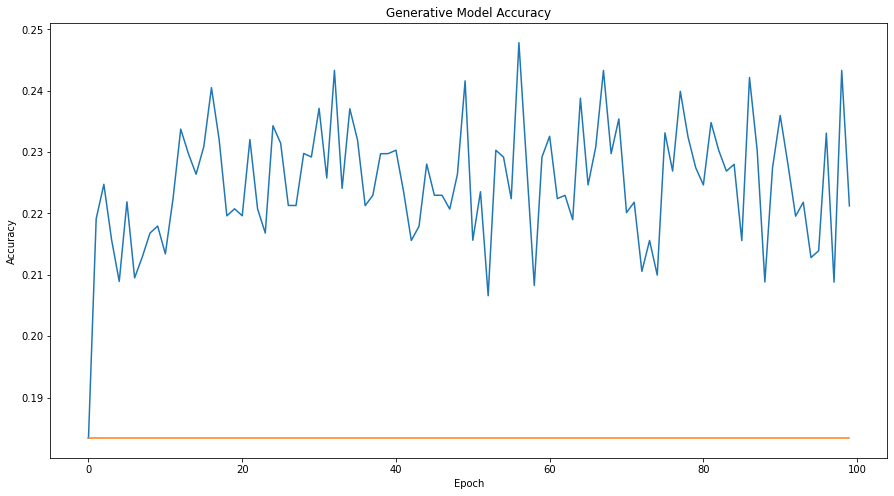

In [25]:
plt.figure(figsize=(15,8))
plt.title("Generative Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(total_acc_set)
plt.plot(base_acc_set)
plt.show()

In [26]:
print(total_acc_set[0])
print(total_acc_set[49])
print(total_acc_set[99])

0.18339460491764145
0.24162329911673433
0.2212397549136628


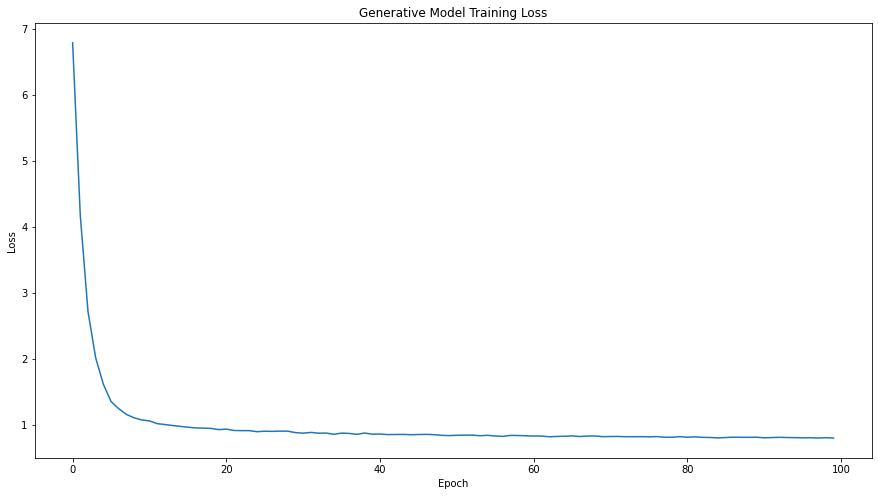

In [28]:
plt.figure(figsize=(15,8))
plt.title("Generative Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_per_epoch)
plt.show()

## Evaluate Both Models on Test Set

In [29]:
test_df

,Unnamed: 0,rule,stimulus,response,multi_toks_or_oov
358,358,associate,resistance,stop,False
1983,1983,rhyme,page,massage,False
539,539,category,crime,homicide,False
1478,1478,synonym,hardly,just,False
249,249,associate,zoo,animal,False
...,...,...,...,...,...
1884,1884,rhyme,copper,driver,False
1867,1867,rhyme,good,mood,False
792,792,category,drug,cocaine,False
239,239,associate,umpire,decision,False


In [30]:
test_sentences, test_targets = eval_mask(test_df)

In [31]:
t_input_ids, t_label_ids, t_attention_masks = eval_tokenize(test_sentences, test_targets)

print (len(t_input_ids), len(t_label_ids))
print ("Tokenized first sentence:")
print (test_sentences[0], t_input_ids[0])
print (test_targets[0], t_label_ids[0])

443 443
Tokenized first sentence:
[CLS] resistance is [MASK] of stop [SEP] [ 101 5012 2003  103 1997 2644  102    0    0    0    0    0    0    0
    0    0]
(3, 'associate') [  -1   -1   -1 5482   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1]


In [32]:
test_inputs = torch.tensor(t_input_ids)
test_masks = torch.tensor(t_attention_masks)
test_labels = torch.tensor(t_label_ids)

In [33]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [34]:
model_read.eval()
model_genr.eval()

# Tracking variables 
test_matrix_read = np.zeros((5, 5))
test_matrix_genr = np.zeros((5, 5))

# # Add data to GPU
test_inputs = test_inputs.to(device)
test_masks = test_masks.to(device)
test_labels = test_labels.to(device)

# Telling the model not to compute or store gradients, saving memory and speeding up validation
with torch.no_grad():
  # Forward pass, calculate logit predictions
  logits = model_read(test_inputs, token_type_ids=None, attention_mask=test_masks)
# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()
label_ids = test_labels.to('cpu').numpy()
test_matrix_read += confusion_matrix_rules(logits, label_ids)
y_read = logits

with torch.no_grad():
  # Forward pass, calculate logit predictions
  logits = model_genr(test_inputs, token_type_ids=None, attention_mask=test_masks)
# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()
label_ids = test_labels.to('cpu').numpy()
test_matrix_genr += confusion_matrix_rules(logits, label_ids)
y_genr = logits

print('\nTest Accuracy - Read:', accuracy_per_class(test_matrix_read))
print('\nTest Accuracy - Genr:', accuracy_per_class(test_matrix_genr))


Test Accuracy - Read: [0.05617978 0.11363636 0.47191011 0.27272727 0.02247191]

Test Accuracy - Genr: [0.12359551 0.34090909 0.39325843 0.125      0.14606742]


## Analysis

In [35]:
template_rule_lst = ['associate', 'category', 'antonym', 'synonym', 'rhyme']

In [36]:
print("Epoch 100:\n")
print("Evaluation Data Confusion Matrix for Read-only Model\n", conf_matr_set[-1][0])

print("\nEvaluation Data Confusion Matrix for Generative Model\n", conf_matr_set[-1][1])

Epoch 100:

Evaluation Data Confusion Matrix for Read-only Model
 [[ 30.  89. 145.  88.   2.]
 [ 75.  49.  67. 164.   0.]
 [  1.  66. 155. 130.   2.]
 [ 22.  85. 158.  90.   0.]
 [ 36.  54. 128. 135.   1.]]

Evaluation Data Confusion Matrix for Generative Model
 [[ 43. 188.  77.  31.  15.]
 [109. 117.  76.  53.   0.]
 [ 24. 136. 147.  42.   5.]
 [ 58. 165.  89.  27.  16.]
 [ 64.  95. 100.  37.  58.]]


In [37]:
## Looking at the plot differences in the reading-only model and the generative-model

In [38]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

In [39]:
print("Test Data Confusion Matrix for Read-only Model\n", test_matrix_read)

print("\nTest Data Confusion Matrix for Generative Model\n", test_matrix_genr)

Test Data Confusion Matrix for Read-only Model
 [[ 5. 27. 37. 19.  1.]
 [18. 10. 20. 40.  0.]
 [ 0. 16. 42. 31.  0.]
 [ 7. 21. 36. 24.  0.]
 [ 7. 11. 38. 31.  2.]]

Test Data Confusion Matrix for Generative Model
 [[11. 42. 25.  9.  2.]
 [27. 30. 19. 12.  0.]
 [ 6. 31. 35. 17.  0.]
 [18. 35. 23. 11.  1.]
 [11. 28. 26. 11. 13.]]


Confusion Matrix for Test Set, Read-Model
Accuracy:  0.18738508682328905


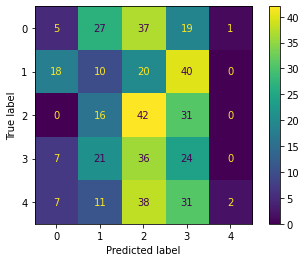

In [40]:
print("Confusion Matrix for Test Set, Read-Model")
cmd_read = ConfusionMatrixDisplay(test_matrix_read).plot()

acc = np.sum(accuracy_per_class(test_matrix_read)) / 5
print("Accuracy: ", acc)

Confusion Matrix for Test Set, Generate-Model
Accuracy:  0.22576608784473953


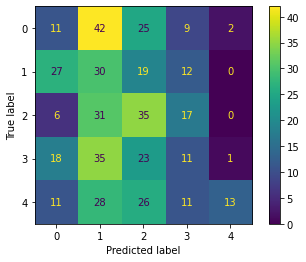

In [41]:
print("Confusion Matrix for Test Set, Generate-Model")
cmd_genr = ConfusionMatrixDisplay(test_matrix_genr).plot()

acc = np.sum(accuracy_per_class(test_matrix_genr)) / 5
print("Accuracy: ", acc)

In [42]:
class_acc_read = list(accuracy_per_class(test_matrix_read))
class_acc_genr = list(accuracy_per_class(test_matrix_genr))

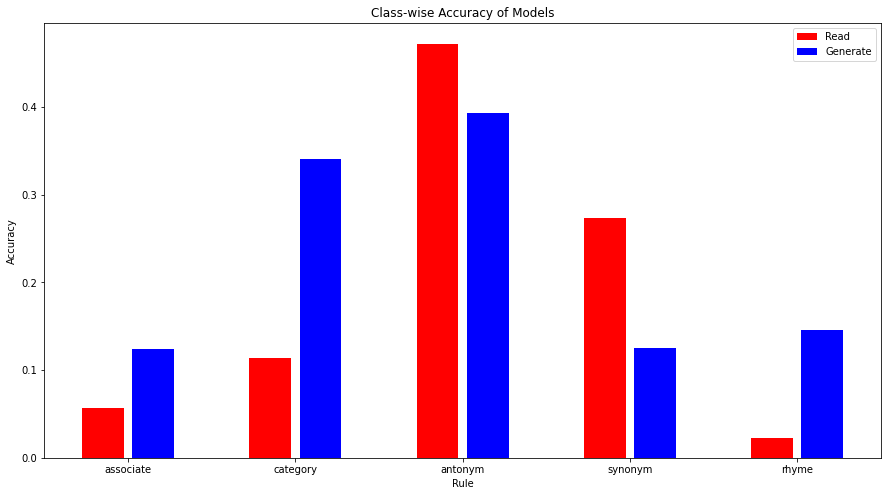

In [49]:
plt.figure(figsize=(15,8))
plt.title("Class-wise Accuracy of Models")

bar_w = 0.25
bar_read = np.arange(5)
bar_genr = [x + bar_w + 0.05 for x in bar_read]

plt.bar(bar_read, class_acc_read, color='red', width=bar_w, label='Read')
plt.bar(bar_genr, class_acc_genr, color='blue', width=bar_w, label='Generate')

plt.xlabel("Rule")
plt.ylabel("Accuracy")
plt.xticks([r + 0.5*bar_w +0.025 for r in range(5)], template_rule_lst)
plt.legend()
plt.show()

### McNemar's Test for Improvement in Accuracy

In [44]:
from statsmodels.stats.contingency_tables import mcnemar, Table

In [45]:
def contigency_table(preds, labels, tok_pos=3, index=0):
  rule_preds = preds[:, tok_pos, rule_vocab_ids]
  predts_flat = np.argmax(rule_preds, axis=1).flatten()

  rule_preds = labels[:, tok_pos, rule_vocab_ids]
  labels_flat = np.argmax(rule_preds, axis=1).flatten()

  labels_mat = one_hot(labels_flat, 5).reshape([-1, 5, 1])
  predts_mat = one_hot(predts_flat, 5).reshape([-1, 5, 1])

  q1, q2, q3, q4 = 0, 0, 0, 0
  for i in range(len(labels_mat)):
    if labels_mat[i][index] == 0:
      if predts_mat[i][index] == 0:
        q4 += 1
      else:
        q3 += 1
    else:
      if predts_mat[i][index] == 0:
        q2 += 1
      else:
        q1 += 1

  return [[q1, q2], [q3, q4]]

In [46]:
contigency_table(y_read, y_genr, index=0)

[[18, 55], [19, 351]]

In [48]:
print("Statistical Significance")

class_stats_set = []

for i in range(5):

  c_t = contigency_table(y_read, y_genr, index=i)
  result = mcnemar(c_t, exact=True)
  stat, p = result.statistic, result.pvalue

  class_stats_set.append((stat, p))

  print("\n", template_rule_lst[i], ": p-value = ", p, " ~ %.10f" %p)

Statistical Significance

 associate : p-value =  3.376813810738312e-05  ~ 0.0000337681

 category : p-value =  5.83538118989512e-12  ~ 0.0000000000

 antonym : p-value =  0.00020947054060672137  ~ 0.0002094705

 synonym : p-value =  2.6418869265765717e-13  ~ 0.0000000000

 rhyme : p-value =  0.002349853515625  ~ 0.0023498535
